# Germany Inc Shareholders - Consolidation

**Note:** If you would like to use the table of contents below to navigate to sections of the document, please click [here](https://nbviewer.org/github/KensingtonOscupant/germanyinc-shareholders/blob/main/src/exploration.ipynb).

## Table of contents

[I. Loading the data](#section_id1)  
[II. Preprocessing](#section_id2)  
&nbsp;&nbsp;&nbsp;&nbsp;[1. Overview](#section_id3)  
&nbsp;&nbsp;&nbsp;&nbsp;[2. Preprocessing](#section_id4)  
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;[a. Using the cleaning script from "Key Identity"](#section_id5)  
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;[b. Using information from "Key Identity"](#section_id6)  
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;[c. Establishing a ground truth](#section_id7)  
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;[aa. Reconciling data with the OpenCorporates Reconciliation API](#section_id8)  
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;[bb. Retrieving previous company names from OpenCorporates](#section_id9)  
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;[cc. Matching notifying parties using GPT3.5](#section_id10)  


<a id='section_id1'></a>

## I. Loading the data

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Read the data
df = pd.read_csv('../data/mydata.csv', low_memory=False)
# Print the first few rows of the data
df.head()

,Unnamed: 0,issuer,domicile,state,notifying_party,domicile_not,total_participation_shares,participation_instruments,aggregation,publication,direct_participation,single_rights_1,attributable_participation,single_rights_2,single_rights_3,gazette_1,gazette_2,state_2,date,table_date
0,1,A.A.A. Aktiengesellschaft Allgemeine Anlagever...,Frankfurt am Main,NaN,ROTHENBERGER Vermögensverwaltung GbR 4xS,NaN,29.62,NaN,NaN,1999-05-11,29.62,NaN,NaN,NaN,NaN,Börsen-Zeitung,NaN,NaN,NaN,200001.0
1,2,A.A.A. Aktiengesellschaft Allgemeine Anlagever...,Frankfurt am Main,NaN,"Rothenberger, Dr., Helmut",NaN,11.93,NaN,NaN,1995-10-07,11.93,NaN,NaN,NaN,NaN,Börsen-Zeitung,NaN,NaN,NaN,200001.0
2,3,A.S. Création Tapeten Aktiengesellschaft,Gummersbach,NaN,"Schneider, Franz Jürgen",NaN,33.10,NaN,NaN,1998-07-08,33.10,NaN,NaN,NaN,NaN,Handelsblatt,NaN,NaN,NaN,200001.0
3,4,A.S. Création Tapeten Aktiengesellschaft,Gummersbach,NaN,3i Group plc,NaN,23.34,NaN,NaN,1998-07-08,0.00,NaN,23.34,NaN,NaN,Handelsblatt,NaN,NaN,NaN,200001.0
4,5,A.S. Création Tapeten Aktiengesellschaft,Gummersbach,NaN,3i Deutschland Gesellschaft für Industriebetei...,NaN,23.34,NaN,NaN,1998-07-08,23.34,NaN,NaN,NaN,NaN,Handelsblatt,NaN,NaN,NaN,200001.0


<a id='section_id2'></a>

## II. Preprocessing

<a id='section_id3'></a>

### 1. Overview

In order to implement any of the rules, we need to consolidate the list of shareholders. First, I will group all entries by exact matches and sort them from the largest to smallest group. Then, I will create a plot that shows the first 100 rows of that sorted dataframe.



14457


,notifying_party,counts
1858,"BlackRock, Inc.",9412
1172,Axxion S.A.,4951
3201,DWS Investment GmbH,4218
822,Allianz Global Investors GmbH,3636
12661,"The Capital Group Companies, Inc.",3251
13072,Universal-Investment-Gesellschaft mit beschrän...,3142
1392,Baden-Württembergische Versorgungsanstalt für ...,2926
7451,LBBW Asset Management Investmentgesellschaft mbH,2740
1846,"BlackRock Holdco 2, Inc.",2735
14169,"Zours, Wilhelm Konrad Thomas",2609


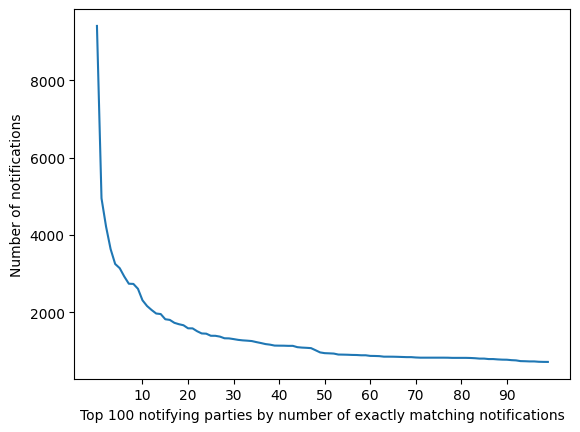

In [2]:
# group by notifying party and aggregate the number of entries
df_grouped = df.groupby(['notifying_party']).size().reset_index(name='counts')
print(len(df_grouped))
# sort this dataframe by the number of entries
df_grouped = df_grouped.sort_values(by=['counts'], ascending=False)
# plot only every 100th entry to generate it faster
sns.lineplot(x='notifying_party', y='counts', data=df_grouped[:100])

# Set custom x-axis and y-axis labels
plt.xlabel('Top 100 notifying parties by number of exactly matching notifications')
plt.ylabel('Number of notifications')

# Set custom x-axis tick locations and labels
tick_locations = range(10, 100, 10)
tick_labels = [str(i) for i in tick_locations]

plt.xticks(tick_locations, tick_labels)

df_grouped.head(20)


Among the shareholders with the highest numbers of records, there is a high number of asset managers. The largest groups also account for the bulk of the overall number of records. This can also be spot-checked by inserting a statement like df_grouped['counts'].iloc[some index, like 5846 or 11937 or 14101] below the line where dataframe is sorted.

<a id='section_id4'></a>

### 2. Preprocessing steps

To consolidate the the data, we first need to ensure that each notifying party does not appear as two or more seemingly distinct entities in the data. Firstly, we will therefore focus on consolidating the unique values in the notifying_party column.

In [3]:
# create a dataframe with just the unique notifying parties
unique_notifying_parties = df.drop_duplicates(subset=['notifying_party'], keep='first')

# drop all other columns
unique_notifying_parties = unique_notifying_parties[['notifying_party']]

# # Export the unique notifying parties to a CSV file
# # pd.DataFrame(unique_notifying_parties, columns=['notifying_party']).to_csv('unique_notifying_parties.csv', index=False)

<a id='section_id5'></a>

#### a. Data cleaning

Before properly working with the data, I applied some simple cleaning rules with regex:

In [4]:
import re

def clean_name(name):
    if type(name) == str:
        name = name.lower()
        name = re.sub('aktiengesellschaft', 'ag', name)
        name = re.sub('kommanditgesellschaft auf aktien', 'kgaa', name)
        name = re.sub('&', 'und', name)
        name = re.sub('ß', 'ss', name)
        name = re.sub('ö', 'oe', name)
        name = re.sub('ü', 'ue', name)
        name = re.sub('ä', 'ae', name)
        name = re.sub('i\.l\.', '', name)
        name = re.sub('i\.k\.', '', name)
        name = re.sub('i\.a\.', '', name)
        name = re.sub('i\.a', '', name)
        name = re.sub('\-', '', name)
        name = re.sub('\:', '', name)
        name = re.sub('_', '', name)
        name = re.sub('\+', '', name)
        name = re.sub(',', '', name)
        name = re.sub('\?', '', name)
        name = re.sub("'", '', name)
        name = re.sub('\.', '', name)
        name = re.sub('/', '', name)
        name = re.sub('!', '', name)
        name = re.sub('<', '', name)
        name = re.sub('>', '', name)
        name = re.sub('"', '', name)
        name = re.sub('„', '', name)
        name = re.sub('“', '', name)
        name = re.sub('”', '', name)
        name = re.sub('·', '', name)
        name = re.sub('\s', '', name)
        name = name.strip()
    return name

<a id='section_id6'></a>

#### b. Using information already collected elsewhere in the project

From the "Key" part of the Germany Inc. project, we already have a list that contains all spellings of the companies as they appear in the "issuers" column. Spellings that belong to one company have been assigned the same `company_id`. Since this dataframe does not only focus on different spellings, but on different spelling-ISIN combinations, the same spellings appear multiple times. To get a list of all unique spellings, we will drop duplicates on the `name` column:

In [5]:
df_dba_spellings = pd.read_csv('../data/names.csv')
print(len(df_dba_spellings))
df_dba_spellings.drop_duplicates(subset=['name'], inplace=True)
df_dba_spellings.head()

17821


,Unnamed: 0,wkn,name,isin,ag,id,company_id
0,1,121806,Altira Aktiengesellschaft,DE0001218063,altiraag,1,1
1,2,121806,FinLab AG,DE0001218063,finlabag,1,1
2,3,121806,Themis Capital Group AG,NaN,themiscapitalgroupag,1,1
3,4,126174,UTIMACO Safeware Aktiengesellschaft,DE0001261741,utimacosafewareag,2,2
4,5,126174,Utimaco Safeware AG,DE0001261741,utimacosafewareag,2,2


To find alias groups in our dataframe of different spellings of issuers, we will join `df_dba_spellings` on the `notifying_party` column of the `unique_notifying_parties`. Now, we can filter for records that were successfully matched, i.e. where `company_id` is not NaN and group these records by `company_id` to see which companies have how many aliases present in their data:

In [14]:
unique_notifying_parties_with_company_id_notna = unique_notifying_parties.merge(
    df_dba_spellings,
    left_on='notifying_party',
    right_on='name',
    how='left'
).dropna(subset=['company_id'])

print("Number of matched records from unique_notifying_parties:", len(unique_notifying_parties_with_company_id_notna))


# group by company_id and aggregate the number of entries
df_grouped = unique_notifying_parties_with_company_id_notna.groupby(['company_id']).size().reset_index(name='counts')
df_grouped.head()

Number of matched records from unique_notifying_parties: 666


,company_id,counts
0,1.0,2
1,4.0,1
2,5.0,5
3,6.0,3
4,8.0,1


The following bar chart indicates how often alias groups of size n=1, 2, 3, 4 and 5 appear:

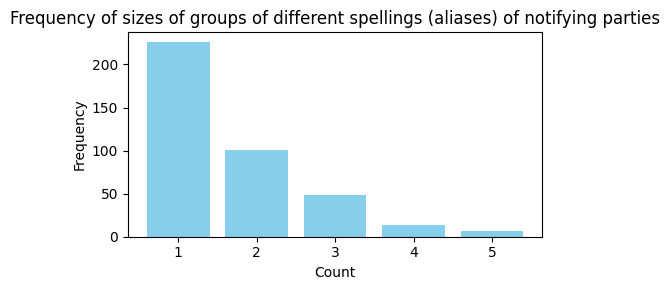

In [8]:
# Calculate the histogram of 'counts'
hist_counts = df_grouped['counts'].value_counts().reset_index().sort_values(by='index')

# Create the bar chart
plt.figure(figsize=(5, 3))  # Adjust the figure size as needed
plt.bar(hist_counts['index'], hist_counts['counts'], color='skyblue')
plt.xlabel('Count')
plt.ylabel('Frequency')
plt.title('Frequency of sizes of groups of different spellings (aliases) of notifying parties')
plt.xticks(hist_counts['index'])  # Set x-axis ticks to the unique count values

# Show the plot
plt.tight_layout()
plt.show()

We will set all this information aside for now and use it later.

<a id='section_id7'></a>

#### c. Establishing a ground truth

Using information from other sections of the project is a good start, but does not give us certainty regarding the question how many notifying parties exist in our dataset overall. Initially, we considered a fuzzy matching approach using the Levenshtein distance to compare similar strings against each other, which would have allowed us to form groups of strings above a certain similarity threshold and then treat every group as a separate notifying party. For an explanation on how to leverage fuzzy matching for such a task see an [earlier version of this notebook](https://nbviewer.org/github/KensingtonOscupant/germanyinc-shareholders/blob/3ed7e945e3f4b0c8a9abe9b4b58b0596da9b4976/src/exploration.ipynb#section_id7). However, this approach has considerable downsides, one of them being that it relies on the assumption that notifying parties only change their names slightly over time, which is not necessarily true. 

Ultimately, we decided against it in favour of using the external database [OpenCorporates](https://opencorporates.com/) as our ground truth. As an open-data project, we were fortunate to receive free API access.

<a id='section_id8'></a>

##### aa. Reconciling data with the OpenCorporates Reconciliation API

Firstly, we used the [OpenCorporates Reconcilition API](https://api.opencorporates.com/documentation/Open-Refine-Reconciliation-API) to match the notifying parties from our BaFin data to the legal corporate entites collected in the OpenCorporates database.  It is possible to use the endpoints from the Reconciliation API on their own, but for simple tasks, this is not even necessary as there is an endpoint specifically made for [OpenRefine](https://openrefine.org/), a free and open-source tool for cleaning, transforming, and enhancing messy and unstructured data. This approach allowed us to match 7454 out of 14457 notifying parties (51%).

*Note to self: The CSV with the safely matched data is combined.csv*

<a id='section_id9'></a>

##### bb. Retrieving previous company names from OpenCorporates

Unfortunately, the OpenCorporates Reconciliation API would not take us any further from here because it matches results based on an internal score that takes into account string similarity and various other factors specific to OpenCorporates data ([OpenCorporates Reconciliation API documentation](https://api.opencorporates.com/documentation/Reconciliation_API_documentation_v0.1.pdf), p. 2). This score cannot be changed by the user, which means that it can also not be configured to match records in a less confident way.

This is why we retrieved previous company names for our notifying parties through the [regular OpenCorporates REST API](https://api.opencorporates.com/documentation/API-Reference) and then matched records that these previous names were matching with.

In [ ]:
import os
import dotenv
import requests
import json
from tqdm import tqdm

# set up environment variables
dotenv.load_dotenv()
OPENCORPORATES_API_KEY = os.getenv("OPENCORPORATES_API_KEY")

In [ ]:
# Set up the OpenCorporates API URL
api_base_url = "https://api.opencorporates.com/v0.4/companies/{}/{}?api_token={}"

# Define a function to retrieve the previous names from the OpenCorporates API for a given URL
def get_previous_names(url):
    # Extract the jurisdiction code and company number from the OpenCorporates URL
    jurisdiction_code, company_number = url.split("/")[-2:]

    # Construct the OpenCorporates API URL using the jurisdiction code, company number, and your API key
    api_url = api_base_url.format(jurisdiction_code, company_number, OPENCORPORATES_API_KEY)

    # Make a GET request to the OpenCorporates API URL and parse the JSON response
    response = requests.get(api_url)
    data = json.loads(response.text)

    # Extract the previous names from the JSON response and return them
    return [name["company_name"] for name in data["results"]["company"].get("previous_names", [])]

Since the connection to the API would cut off every once in a while, it was necessary to split the file into batches and process them separately.

In [ ]:
# Split the original DataFrame into batches of 50 rows each
batch_size = 50
num_batches = df.shape[0] // batch_size + 1
batch_dfs = [df[i * batch_size:(i + 1) * batch_size] for i in range(num_batches)]

In [ ]:
# Loop through the batches
for i, batch_df in tqdm(enumerate(batch_dfs), total=num_batches, desc='Processing batches'):
    batch_df['previous_names'] = batch_df.loc[batch_df['OpenCorporates URL'].notnull(), 'OpenCorporates URL'].apply(get_previous_names)
    
    # Save the modified batch DataFrame to a new CSV file
    batch_df.to_csv(f'batch_{i + 1}.csv', index=False)

Finally, we bring the batches back together into one file:

In [ ]:
# Combine all the smaller batch CSVs into a larger one
combined_df = pd.concat([pd.read_csv(f'batch_{i + 1}.csv') for i in range(num_batches)])

# Save the combined DataFrame to a new CSV file
combined_df.to_csv('combined.csv', index=False)

The result of this was a dataframe that contained the previous names of companies for every OpenCorporates URL (if present). Now we can use the previous names to match records that have a previous name of another record as their `notifying_party` value to their respective OpenCorporates data.

In [ ]:
import ast

# Iterate through each row in the DataFrame
for index, row in df.iterrows():
    # Check if 'previous_names' column has any aliases
    if pd.notna(row['previous_names']):
        # Convert the string representation of the list to an actual list
        aliases = ast.literal_eval(row['previous_names'])
        
        # Iterate through aliases
        for alias in aliases:
            # Remove leading and trailing whitespaces
            alias = alias.strip()
            
            # Check if the alias exists in 'notifying_party' column of other rows
            alias_exists = df[df['notifying_party'] == alias]
            
            if not alias_exists.empty:
                # Get the URL from the row where the alias comes from
                alias_url = row['OpenCorporates URL']
                
                # Update the URL column in rows where the alias appears
                df.loc[alias_exists.index, 'OpenCorporates URL'] = alias_url

# Save the updated DataFrame to a CSV file
df.to_csv('../data/df_with_aliases.csv', index=False)

This allowed us to match another 138 records.

<a id='section_id10'></a>

##### cc. Matching notifying parties using GPT3.5

